### import libs

In [ ]:
import sys
import os
import pandas as pd
import numpy as np

''' Librosa:  is a python package for music and audio analysis.
 It provides the building blocks necessary to create music
 information retrieval systems: https://librosa.org/doc/latest/index.html
 conda install -c conda-forge librosa
 pip install librosa
 '''
import librosa
import librosa.display

import seaborn as sns               #!pip install seaborn
import matplotlib.pyplot as plt    #!pip install matplotlib

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# To play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical   #!pip install keras/conda install keras
from keras.callbacks import ModelCheckpoint




2024-06-17 13:07:30.038569: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-17 13:07:30.039854: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-17 13:07:30.050380: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-17 13:07:30.128553: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 13:07:32.169478: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

## Data Processing

In [ ]:
emoRav = "data/Ravdess/"

'\nEmotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).\nEmotional intensity (01 = normal, 02 = strong). \nnote: There is no strong intensity for the \'neutral\' emotion.\nStatement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").\nRepetition (01 = 1st repetition, 02 = 2nd repetition).\nActor (01 to 24. Odd numbered actors are male, even numbered actors are female).\n'

In [ ]:
ravdess_directory_list = os.listdir(emoRav)
file_emotion = []
file_path = []

for dir in ravdess_directory_list:
    #print(emoRav+dir)
    actor = os.listdir(emoRav+dir)
    #print(actor)
    #print(dir)
    for file in os.listdir(emoRav+dir):
        files = os.listdir(emoRav+dir+"/"+file)
        
        for wav in files:
            part = wav.split('.')[0]
            part = part.split('-')
            
            file_emotion.append(int(part[2]))
            file_path.append(emoRav + dir + '/' +file+'/'+ wav)
            #print(file_path)
            
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])

emoRav_df = pd.concat([emotion_df, path_df], axis =1)        

In [ ]:
# changing integers to actual emotions.
emoRav_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
emoRav_df.head()

/tmp/ipykernel_3062810/1742590396.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  emoRav_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)


,Emotions,Path
0,angry,/home/nasr/GitHub/2024/sem_tut/audio/data/Ravd...
1,happy,/home/nasr/GitHub/2024/sem_tut/audio/data/Ravd...
2,happy,/home/nasr/GitHub/2024/sem_tut/audio/data/Ravd...
3,angry,/home/nasr/GitHub/2024/sem_tut/audio/data/Ravd...
4,happy,/home/nasr/GitHub/2024/sem_tut/audio/data/Ravd...


In [ ]:
emoRav_df1 = emoRav_df.sample(900)
emoRav_df = pd.concat([emoRav_df,emoRav_df1])

In [ ]:
len(emoRav_df)

2340

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def speed_change(data):
    data = librosa.effects.time_stretch(data, rate=1.25)
    return data

## Feature Extraction
Mel-Spectrogram: is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency 
. It is commonly used as a feature for training neural network models in audio classification tasks.

In [ ]:
def feature_extraction(data, sample_rate):
    results=np.array([])
    mel = (librosa.feature.melspectrogram(y=data, sr=sample_rate, n_mels=40))
    power = librosa.power_to_db(mel)
    #print(power.shape) #(128, 108) #(40, 108)
    #librosa.display.specshow(power)



    return mel

def get_features(path):
    result = []
    data, sample_rate = librosa.load(path, duration= 2, offset= 1) #duration and offset are selected based on the dataset 

    res = feature_extraction(data, sample_rate)
    result = np.array(res)
    # data with noise
    noise_data = noise(data)
    res2 = feature_extraction(noise_data, sample_rate)
    #result = np.vstack((result, res2))
    #result.append(res)
    result = result+res2
    

    return result


In [ ]:

# Extract features for all audio files
features = []
max_length = 87  # Maximum length of the feature arrays

for i in range(len(emoRav_df)):
    path = emoRav_df.iloc[i, 1]
    feature = get_features(path)
    
    # Padding or truncating the feature array to ensure consistent shape
    if feature.shape[1] < max_length:
        pad_width = max_length - feature.shape[1]
        feature = np.pad(feature, ((0, 0), (0, pad_width)), mode='constant')
    else:
        feature = feature[:, :max_length]
    
    features.append(feature)
       

# Data Preparation
As of now we have extracted the data, now we need to normalize and split our data for training and testing

In [ ]:
# Convert the list of features to a NumPy array and reshape
X = np.array(features)


In [ ]:
X = X[..., np.newaxis]  # Adding a new axis for the channel dimension
# Create labels
y = emoRav_df['Emotions'].values

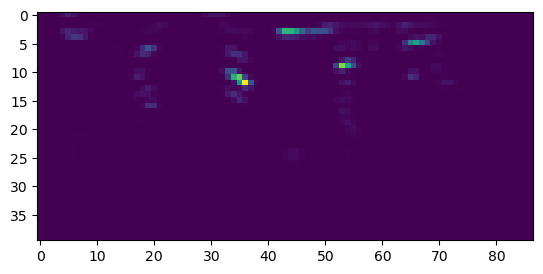

In [ ]:
plt.imshow(X[0])

In [ ]:
len(X), len(y), emoRav_df.Path.shape

(2340, 2340, (2340,))

# Data Preparation
As of now we have extracted the data, now we need to normalize and split our data for training and testing

In [ ]:
# Convert labels to numeric format
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1872, 40, 87, 1), (1872,), (468, 40, 87, 1), (468,))

#### Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

In [ ]:
datagen.fit(X_train)

# Modeling

In [ ]:
# Define the CNN model
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(40, 87, 1)),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),



    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(8, activation='softmax')  # The number of neurons according to the number of classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


/home/nasr/anaconda3/envs/audio/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-17 13:08:44.255609: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-17 13:08:44.257413: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=100,  # Increase the number of epochs if necessary
                    validation_data=(X_test, y_test))

Epoch 1/100
 1/59 ━━━━━━━━━━━━━━━━━━━━ 1:20 1s/step - accuracy: 0.2500 - loss: 5.2136

/home/nasr/anaconda3/envs/audio/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.1838 - loss: 2.6103 - val_accuracy: 0.1432 - val_loss: 2.0051
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1623 - loss: 2.0485 - val_accuracy: 0.1346 - val_loss: 1.9968
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1962 - loss: 1.9726 - val_accuracy: 0.2500 - val_loss: 1.9436
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2584 - loss: 1.9452 - val_accuracy: 0.2821 - val_loss: 1.9238
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2430 - loss: 1.9282 - val_accuracy: 0.2607 - val_loss: 1.8705
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2750 - loss: 1.8298 - val_accuracy: 0.2650 - val_loss: 1.8305
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2512 - loss: 1.8245 - val_accuracy: 0.2885 - val_loss: 1.8028
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2717 - loss: 1.7920 - val_accuracy: 0.2863 - val_l

In [ ]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


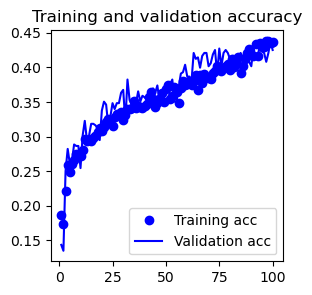

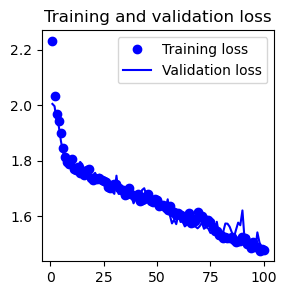

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(3,3))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(3,3))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


## Save the trained model

In [ ]:
model.save('trained_model/Speech_CNN_AFB.h5')

# Explaination: TODO

In [ ]:
from skimage import io
import lime.lime_tabular